In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random
random.seed(42)

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
start_end_char = '.'

chars = sorted(list(set(''.join(words))))

# Create a mapping from character to index
stoi = {s:i+1 for i, s in enumerate(chars)}
# Add a start and end token
stoi[start_end_char] = 0

# Create a mapping from index to character
itos = {k:s for s, k in stoi.items()}
vocab_size = len(stoi)

stoi, itos, vocab_size

({'a': 1,
  'b': 2,
  'c': 3,
  'd': 4,
  'e': 5,
  'f': 6,
  'g': 7,
  'h': 8,
  'i': 9,
  'j': 10,
  'k': 11,
  'l': 12,
  'm': 13,
  'n': 14,
  'o': 15,
  'p': 16,
  'q': 17,
  'r': 18,
  's': 19,
  't': 20,
  'u': 21,
  'v': 22,
  'w': 23,
  'x': 24,
  'y': 25,
  'z': 26,
  '.': 0},
 {1: 'a',
  2: 'b',
  3: 'c',
  4: 'd',
  5: 'e',
  6: 'f',
  7: 'g',
  8: 'h',
  9: 'i',
  10: 'j',
  11: 'k',
  12: 'l',
  13: 'm',
  14: 'n',
  15: 'o',
  16: 'p',
  17: 'q',
  18: 'r',
  19: 's',
  20: 't',
  21: 'u',
  22: 'v',
  23: 'w',
  24: 'x',
  25: 'y',
  26: 'z',
  0: '.'},
 27)

In [5]:
# Building the dataset

# context length: how many characters to look at to predict the next one
block_size = 3

def dataset_builder(words):
    X, Y = [], []

    for word in words:
        # print(word)
        context = [0] * block_size
        for c in word + start_end_char:
            ix = stoi[c]
            X.append(context)
            Y.append(ix)
            # print(''.join([itos[i] for i in context]), '--->', c)
            context = context[1:] + [ix] # crop the first element and add the new one

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    # print(X.shape, Y.shape)
    return X, Y

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

X, Y = dataset_builder(words[:n1]) # 80% of the data
X_val, Y_val = dataset_builder(words[n1:n2]) # 10% of the data
X_test, Y_test = dataset_builder(words[n2:]) # 10% of the data

In [6]:
# For reproducibility
g = torch.Generator().manual_seed(2147483647)

n_embd = 10
n_hidden = 200
weights_dim = block_size * n_embd

# Initialize the parameters
C = torch.randn((vocab_size, n_embd),       generator=g)

# Use the kaiming initialization to initialize W1
# https://arxiv.org/abs/1502.01852
# https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.normal_
# tanh gain = 5/3
W1 = torch.randn((weights_dim, n_hidden),   generator=g) * (5/3) / (weights_dim**0.5) # * 0.2

# Batch normalization has a bias, so we don't need to initialize it
# b1 = torch.randn(n_hidden,                  generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size),    generator=g) * 0.01
b2 = torch.randn(vocab_size,                generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

print(sum(p.numel() for p in parameters))

12297


tensor(-0.0064) tensor(1.0060)
tensor(0.0050) tensor(0.9696)


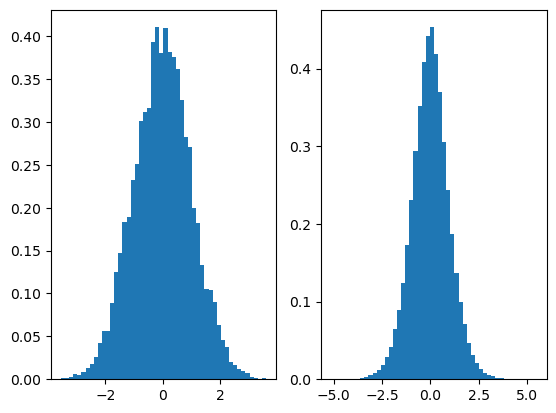

In [7]:
x = torch.randn(1000, 10)
# w = torch.randn(10, 200)
# To prevent the expansion of the distribution divide by sqrt(number of dimension) or sqrt(fan_in)
w = torch.randn(10, 200) * (5/3) / (weights_dim**0.5)

# When we use a dot product the standart deviation is growning
y = x @ w

print(x.mean(), x.std())
print(y.mean(), y.std())
(5/3) * (weights_dim**0.5)
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);

plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [8]:
max_steps, batch_size, lossi = 200000, 32, []

for i in range(max_steps):
    # Minibatch construction
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    Xb, Yb = X[ix], Y[ix] # batch X, Y

    # Forward pass
    emb = C[Xb].view(-1, weights_dim)
    # Hidden layer preactivation, linear layer
    preact = emb @ W1 # + b1 
    
    # Batch normalization layer
    bnmeani = preact.mean(0, keepdim=True)
    bnstdi = preact.std(0, keepdim=True)

    preact = bngain * (preact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        # Every step we update the running mean and standard deviation slightly
        # At the end of the training we'll have approximately the same mean and standard deviation
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    # Add non-linearities
    h = torch.tanh(preact) # hidden representation
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Y[ix]) # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update the parameters
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track the learning rate and the loss
    if i % 10000 == 0: 
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    # break

print(loss.item())

      0/ 200000: 3.3442
  10000/ 200000: 2.1095
  20000/ 200000: 1.9760
  30000/ 200000: 1.7753
  40000/ 200000: 2.0790
  50000/ 200000: 1.9369
  60000/ 200000: 2.5229
  70000/ 200000: 2.4514
  80000/ 200000: 1.7932
  90000/ 200000: 2.2978
 100000/ 200000: 2.1749
 110000/ 200000: 2.0796
 120000/ 200000: 1.9102
 130000/ 200000: 1.9998
 140000/ 200000: 2.1022
 150000/ 200000: 2.3006
 160000/ 200000: 1.9463
 170000/ 200000: 2.1586
 180000/ 200000: 2.1738
 190000/ 200000: 1.7376
2.2103285789489746


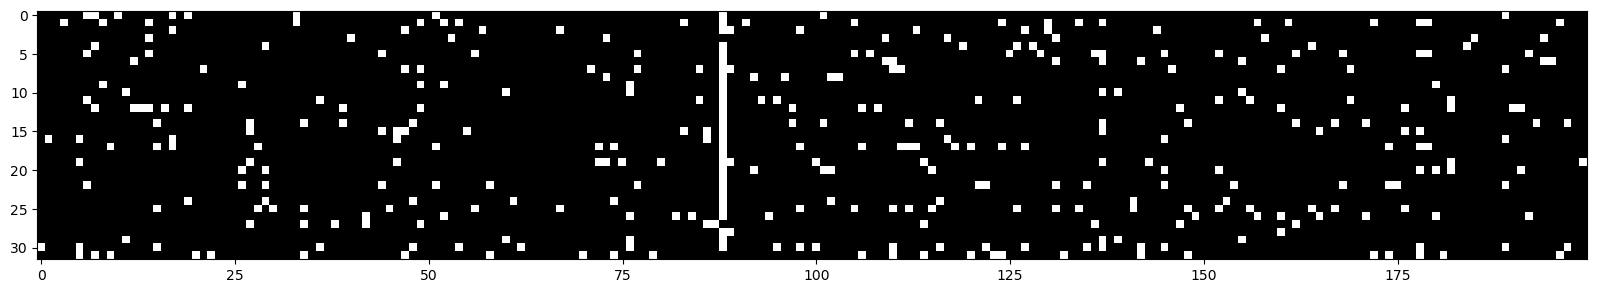

In [9]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

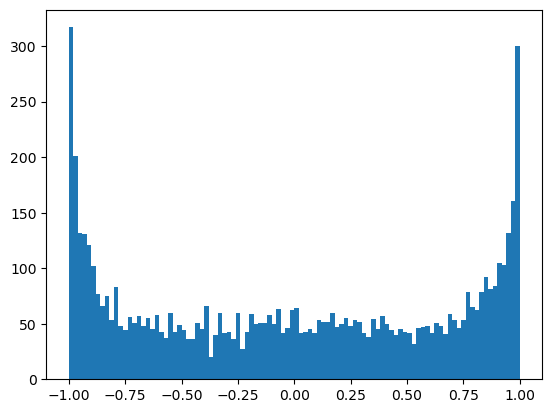

In [10]:
plt.hist(h.view(-1).tolist(), bins=100);

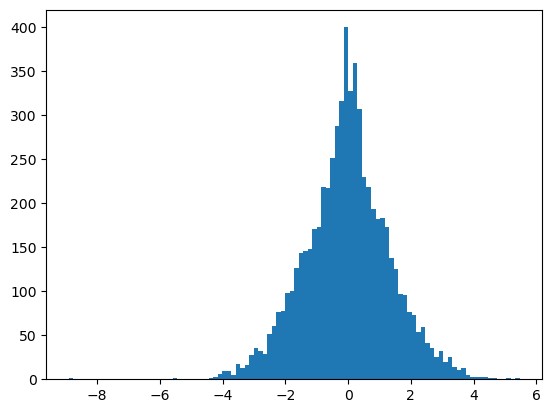

In [11]:
plt.hist(preact.view(-1).tolist(), bins=100);

In [12]:
# 4 dim example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

In [13]:
# Approximate default loss result for our model
-torch.tensor(1/27.0).log()

tensor(3.2958)

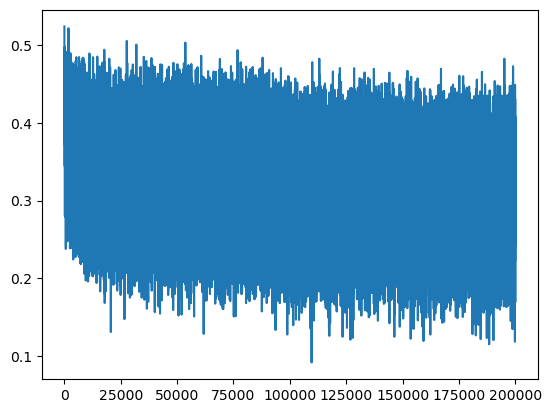

In [14]:
plt.plot(lossi)

In [15]:
# Calibraiting the batch normalization at the end of the training

with torch.no_grad():
    emb = C[X].view(-1, weights_dim)
    preact = emb @ W1 + b1

    # Measure the mean and standard deviation of the batch
    bnmean = preact.mean(0, keepdim=True)
    bnstd = preact.std(0, keepdim=True)

# Compare with bnmean_running and bnstd_running
print(f"bnmean: {bnmean}, bnmean_running: {bnmean_running}")
print(f"bnstd: {bnstd}, bnstd_running: {bnstd_running}")

bnmean: tensor([[-1.7137,  0.6245, -1.7781,  0.4023,  1.4183,  0.9603,  1.2618, -0.4461,
          0.9268,  1.5451, -3.1922, -2.0100, -0.3813, -0.5822, -0.3553,  0.0583,
          0.0982, -2.4711, -1.1761,  1.5233, -0.4106,  0.4347, -0.9634,  0.4113,
          1.6320,  0.5254,  0.7387, -0.4716,  1.0017,  1.9561,  0.3670, -1.0919,
          0.3827,  0.8719, -1.9430, -0.7489,  0.4571,  0.1121, -1.7301,  0.6376,
         -0.3626, -1.0812, -1.2356,  0.1669,  0.3036, -0.3499,  1.9911, -1.2692,
          2.0222,  1.4408,  1.3138, -0.5011,  2.0356,  0.1314,  0.9189, -2.7996,
         -0.9294,  0.3704,  1.0863, -1.1568, -0.6626,  0.8491,  1.2819, -0.6609,
          0.9416,  1.5677, -0.5504,  1.7861, -0.2573, -0.1660,  0.7696,  1.4090,
         -0.0519, -1.6250, -2.3993,  1.1181,  1.0968, -0.2482, -0.3052,  0.5470,
          0.0653,  2.0430,  1.1427,  1.6639,  0.4644,  0.6187, -0.6262, -0.3878,
          1.8060, -0.0804, -0.1906,  1.2181, -0.4912, -0.6704, -1.3906,  0.3009,
          0.2898, -1

In [19]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (X, Y),
        'val': (X_val, Y_val),
        'test': (X_test, Y_test)
    }[split]
    emb = C[x].view(-1, weights_dim)
    preact = emb @ W1 + b1
    preact = bngain * (preact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(preact)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, y).item()

loss_train, loss_val = split_loss('train'), split_loss('val')
print(f'Train loss: {loss_train:.4f}, Val loss: {loss_val:.4f}')

Train loss: 2.0181, Val loss: 2.3217


In [17]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size

    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # Update the context
        context = context[1:] + [ix]
        out.append(ix)
        # If we generated the end token, stop
        if ix == 0:
            break
    # Decode and print the generated word
    print(''.join([itos[i] for i in out[:-1]])) 

brithlisantryelledhnnalizellastondrleg
stze
daeliahnnysophreksis
stanastaphtimhttly
brshdunridhiriestri
jostlynn
gthuttzu
zaghd
riyah
fyeks
khasqusflldvihan
sadylisuf
zajhlvyannnysle
ksvikotgynfredrnykkobobbggpricksamathli
hmritzlidgsir
favrnyssa
tyidhvissitte
gyika
britgf
dvallivya


In [6]:
# Let's train a deep neural network

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.randn((fan_out), generator=g) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim: int, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x: torch.Tensor):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # Update the buffer
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


In [29]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make it less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3 # 5/3 is the gain of tanh for kaiming init

parameters = [C] + [p for layer in layers for p in layer.parameters()]

# same optimization as before
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47551


In [30]:
# Same optimization as before
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
    Xb, Yb = X[ix], Y[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i == 1000:
        break

      0/ 200000: 3.3304


layer 2 Tanh: mean -0.01, std 0.63, saturation 3.41%
layer 5 Tanh: mean -0.00, std 0.64, saturation 2.97%
layer 8 Tanh: mean -0.00, std 0.64, saturation 2.47%
layer 11 Tanh: mean -0.01, std 0.65, saturation 2.12%
layer 14 Tanh: mean -0.00, std 0.66, saturation 2.06%


Text(0.5, 1.0, 'Activation distribution')

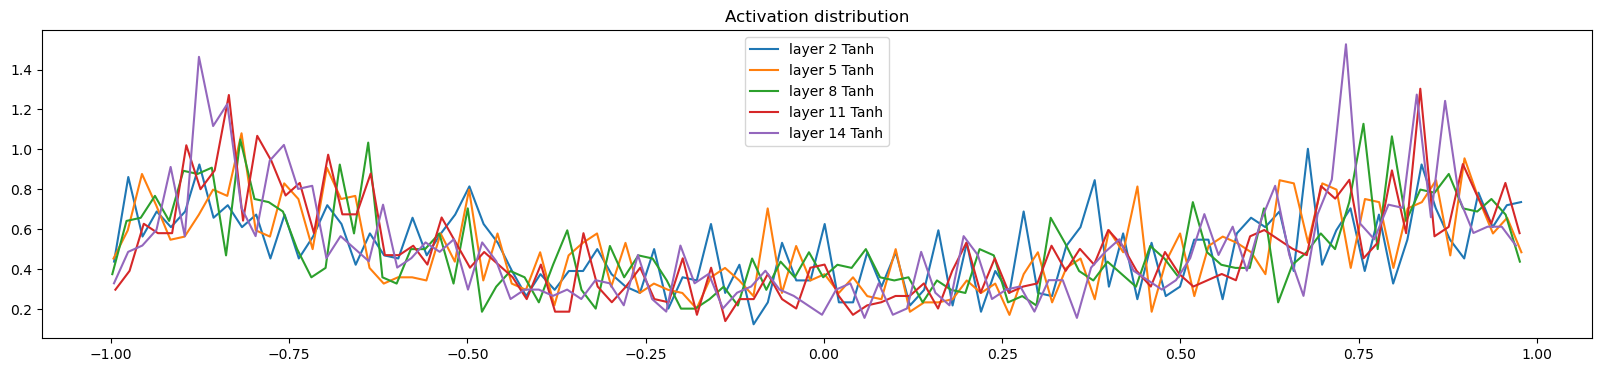

In [31]:
# Visualize histograms

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} {layer.__class__.__name__}: mean {t.mean():.2f}, std {t.std():.2f}, saturation {(t.abs() > 0.97).float().mean() * 100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')

plt.legend(legends)
plt.title("Activation distribution")

layer 2 Tanh: mean -0.00, std 0.00, saturation 0.00%
layer 5 Tanh: mean 0.00, std 0.00, saturation 0.00%
layer 8 Tanh: mean -0.00, std 0.00, saturation 0.00%
layer 11 Tanh: mean -0.00, std 0.00, saturation 0.00%
layer 14 Tanh: mean 0.00, std 0.00, saturation 0.00%


Text(0.5, 1.0, 'Gradient distribution')

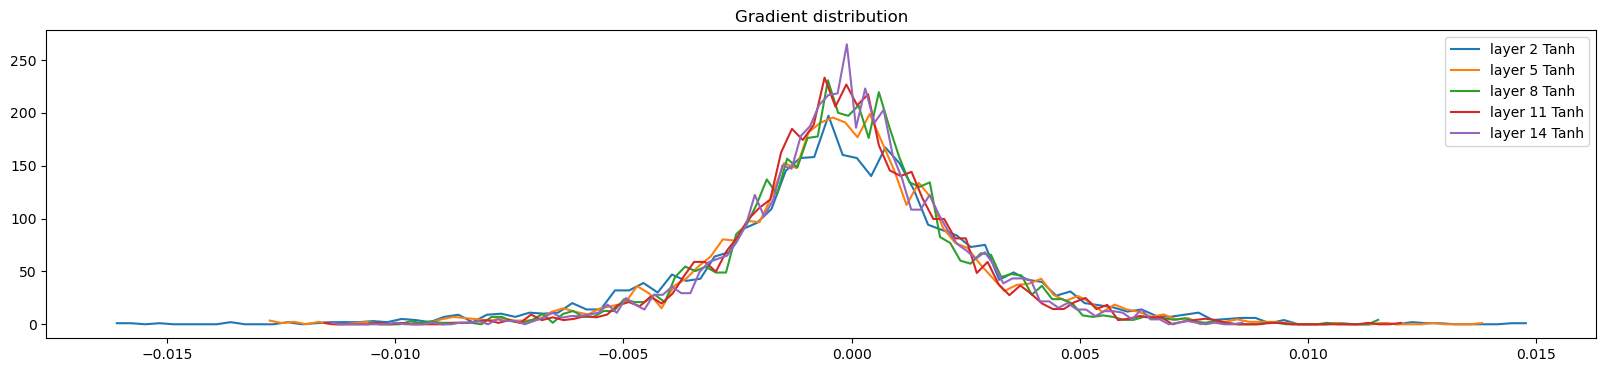

In [32]:
# Visualize histograms

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} {layer.__class__.__name__}: mean {t.mean():.2f}, std {t.std():.2f}, saturation {(t.abs() > 0.97).float().mean() * 100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')

plt.legend(legends)
plt.title("Gradient distribution")

weight   (27, 10) | mean -0.000000 | std 7.011311e-03 | grad:data ratio 7.004180e-03
weight  (30, 100) | mean -0.000023 | std 6.919554e-03 | grad:data ratio 2.213394e-02
weight (100, 100) | mean -0.000047 | std 5.948640e-03 | grad:data ratio 3.543178e-02
weight (100, 100) | mean -0.000034 | std 5.209066e-03 | grad:data ratio 3.134164e-02
weight (100, 100) | mean -0.000076 | std 4.571837e-03 | grad:data ratio 2.734623e-02
weight (100, 100) | mean +0.000023 | std 4.318096e-03 | grad:data ratio 2.575459e-02
weight  (100, 27) | mean +0.000213 | std 8.332143e-03 | grad:data ratio 4.976051e-02


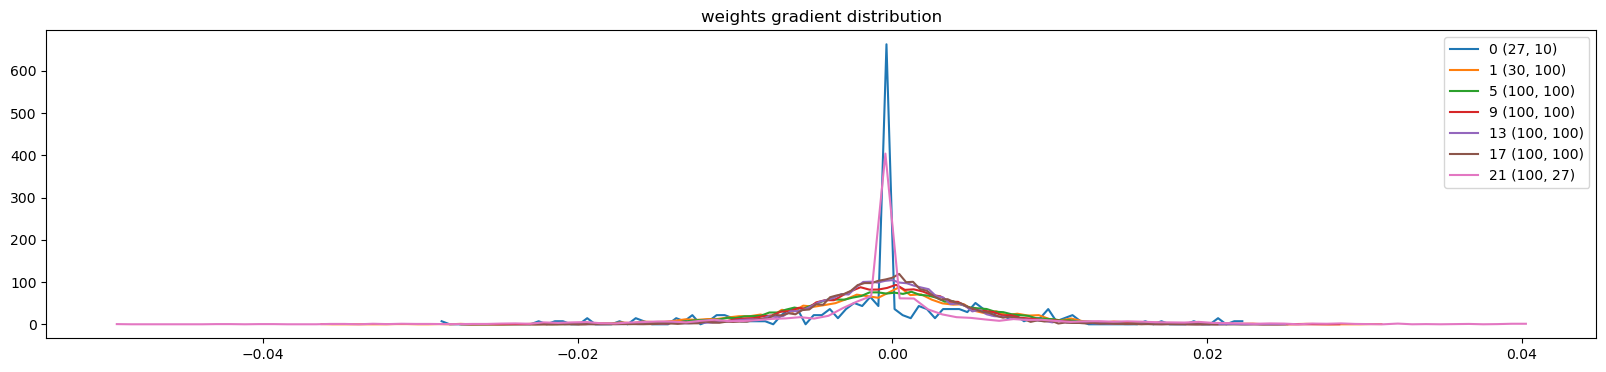

In [33]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []

for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution');

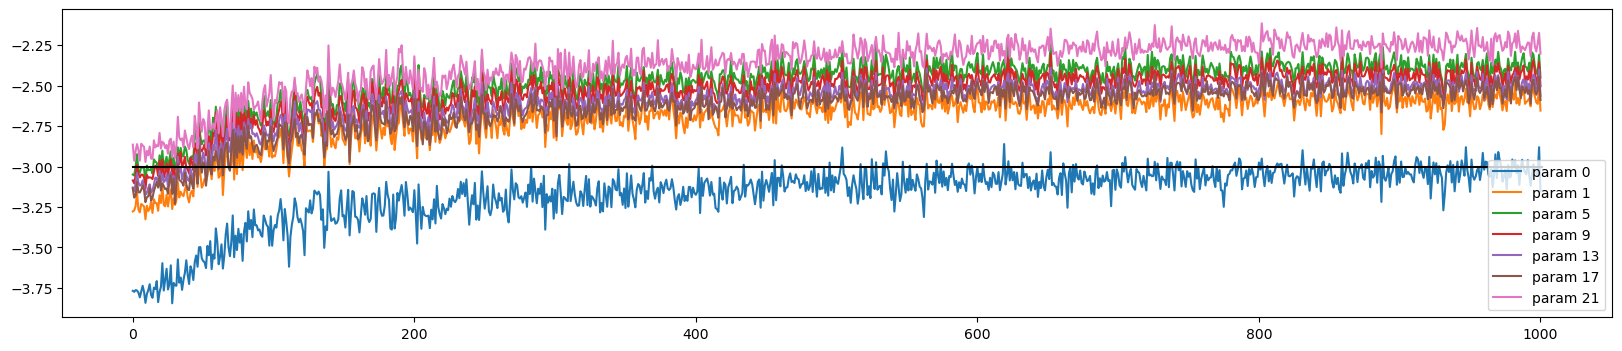

In [34]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
